In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/per

In [2]:

import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization, Embedding, Reshape, Concatenate, LeakyReLU, Conv2DTranspose
from tensorflow.keras import Model  
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications.vgg16 import VGG16
import warnings
warnings.filterwarnings("ignore")

2025-04-30 17:32:05.152815: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746034325.403609      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746034325.469568      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Set dataset directory
base_dir = os.path.join(os.getcwd(), "/kaggle/input/chest-xray-pneumonia/chest_xray")
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "test")
test_dir = os.path.join(base_dir, "val")


In [ ]:

import cv2
import numpy as np

def apply_gaussian_blur(image, kernel_size=(5, 5), sigma=1.0):
    "Applies Gaussian blur to the input image."
    return cv2.GaussianBlur(image, kernel_size, sigmaX=sigma)

In [7]:
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, Embedding
from tensorflow.keras.layers import BatchNormalization, Activation, UpSampling2D, Conv2D, Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam

class CGAN:
    def __init__(self, img_shape, num_classes, latent_dim):
        self.img_shape = img_shape  # e.g., (64, 64, 3)
        self.num_classes = num_classes  # e.g., 2
        self.latent_dim = latent_dim  # e.g., 100
        self.channels = img_shape[2]

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
                                   optimizer=optimizer,
                                   metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # Generator input
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')
        img = self.generator([noise, label])

        # For the combined model we only train the generator
        self.discriminator.trainable = False

        # Discriminator receives generated image and label
        validity = self.discriminator([img, label])

        # Combined model (generator + discriminator)
        self.combined = Model([noise, label], validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')

        label_embedding = Embedding(self.num_classes, self.latent_dim)(label)
        label_embedding = Flatten()(label_embedding)

        model_input = multiply([noise, label_embedding])

        x = Dense(128 * 16 * 16, activation="relu")(model_input)
        x = Reshape((16, 16, 128))(x)

        x = UpSampling2D()(x)  # 32x32
        x = Conv2D(128, kernel_size=3, padding="same")(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = Activation("relu")(x)

        x = UpSampling2D()(x)  # 64x64
        x = Conv2D(64, kernel_size=3, padding="same")(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = Activation("relu")(x)

        img = Conv2D(self.channels, kernel_size=3, padding="same", activation='tanh')(x)

        model = Model([noise, label], img)
        return model

    def build_discriminator(self):
        img = Input(shape=self.img_shape)
        label = Input(shape=(1,), dtype='int32')

        label_embedding = Embedding(self.num_classes, np.prod(self.img_shape))(label)
        label_embedding = Flatten()(label_embedding)
        label_embedding = Reshape(self.img_shape)(label_embedding)

        # Concatenate label embedding and image
        concatenated = concatenate([img, label_embedding])

        x = Conv2D(64, kernel_size=3, strides=2, padding="same")(concatenated)
        x = LeakyReLU(alpha=0.2)(x)
        x = Dropout(0.25)(x)

        x = Conv2D(128, kernel_size=3, strides=2, padding="same")(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Dropout(0.25)(x)

        x = Flatten()(x)
        validity = Dense(1, activation='sigmoid')(x)

        model = Model([img, label], validity)
        return model
    def train(self, epochs, batch_size=128, sample_interval=50):
        # Dummy training data — replace with your actual dataset
        X_train = np.random.randn(1000, *self.img_shape)
        y_train = np.random.randint(0, self.num_classes, 1000)

        # Normalize images to [-1, 1]
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5

        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):
            # ---------------------
            #  Train Discriminator
            # ---------------------
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs, labels = X_train[idx], y_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict([noise, labels], verbose=0)

            d_loss_real = self.discriminator.train_on_batch([imgs, labels], valid)
            d_loss_fake = self.discriminator.train_on_batch([gen_imgs, labels], fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            sampled_labels = np.random.randint(0, self.num_classes, batch_size)

            g_loss = self.combined.train_on_batch([noise, sampled_labels], valid)

            # Handle g_loss safely
            g_loss_value = g_loss[0] if isinstance(g_loss, (list, tuple)) else g_loss

            # Print the progress
            print(f"{epoch} [D loss: {d_loss[0]:.4f}, acc.: {100*d_loss[1]:.2f}%] [G loss: {g_loss_value:.4f}]")

            # Save sample images at intervals
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

   
    def sample_images(self, epoch):
        r, c = 2, 5  # 10 images
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        labels = np.array([num for _ in range(r) for num in range(c % self.num_classes)])

        gen_imgs = self.generator.predict([noise, labels])

        # Rescale to [0,1]
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c, figsize=(c*2, r*2))
        for i in range(r * c):
            axs[i // c, i % c].imshow(gen_imgs[i])
            axs[i // c, i % c].set_title(f"Label: {labels[i]}")
            axs[i // c, i % c].axis("off")
        os.makedirs("images", exist_ok=True)
        fig.savefig(f"images/cgan_{epoch}.png")
        plt.close()



In [8]:
#CGAN model training 
img_shape = (64, 64, 3)  # Example: CIFAR-10. For your data it might be (128,128,3) etc.
num_classes = 10         # Change to match YOUR dataset classes
latent_dim = 100

cgan = CGAN(img_shape, num_classes, latent_dim)
cgan.train(epochs=500, batch_size=64, sample_interval=500)




I0000 00:00:1746034338.580801      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746034338.581528      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
I0000 00:00:1746034340.797197      94 service.cc:148] XLA service 0x792cb4007780 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746034340.797910      94 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1746034340.797933      94 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1746034340.914725      94 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1746034342.769144      94 device_compiler.h:188] Compiled clust

0 [D loss: 0.5853, acc.: 75.00%] [G loss: 0.6229]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1 [D loss: 0.6101, acc.: 58.72%] [G loss: 0.6226]
2 [D loss: 0.6169, acc.: 55.83%] [G loss: 0.6244]
3 [D loss: 0.6208, acc.: 54.51%] [G loss: 0.6260]
4 [D loss: 0.6215, acc.: 53.60%] [G loss: 0.6257]
5 [D loss: 0.6231, acc.: 52.95%] [G loss: 0.6266]
6 [D loss: 0.6238, acc.: 52.50%] [G loss: 0.6268]
7 [D loss: 0.6245, acc.: 52.17%] [G loss: 0.6272]
8 [D loss: 0.6248, acc.: 51.83%] [G loss: 0.6274]
9 [D loss: 0.6257, acc.: 51.56%] [G loss: 0.6280]
10 [D loss: 0.6271, acc.: 51.41%] [G loss: 0.6294]
11 [D loss: 0.6280, acc.: 51.29%] [G loss: 0.6303]
12 [D loss: 0.6296, acc.: 51.18%] [G loss: 0.6319]
13 [D loss: 0.6309, acc.: 51.10%] [G loss: 0.6333]
14 [D loss: 0.6329, acc.: 50.97%] [G loss: 0.6355]
15 [D loss: 0.6357, acc.: 50.91%] [G loss: 0.6385]
16 [D loss: 0.6389, acc.: 50.85%] [G loss: 0.6420]
17 [D loss: 0.6430, acc.: 50.80%] [G loss: 0.6465]
18 [D loss: 0.6480, acc.: 50.76%] [G loss: 0.6521]
19 [D

In [9]:
from keras.applications import VGG16
#CGAN

def get_vgg16_classifier(input_shape=(224, 224, 3), num_classes=2):
    base = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    base.trainable = False  # Freeze for transfer learning

    x = Flatten()(base.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(base.input, output)
    return model


In [10]:

from tensorflow.keras.layers import GlobalAveragePooling2D
model = get_vgg16_classifier(input_shape=(224, 224, 3), num_classes=4)

# Load base VGG model
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base layers (except the last few)
# Unfreeze the last 4 convolutional layers
for layer in model.layers[:-4]:
    layer.trainable = False

for layer in model.layers[-4:]:
    layer.trainable = True
x = vgg.output
x = GlobalAveragePooling2D()(x)  # This flattens the 7x7x512 -> 512
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(2, activation='softmax')(x)

# Build the model
model = Model(inputs=vgg.input, outputs=output)
model.summary()



58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         131,3

 Total params: 14,846,530 (56.64 MB)

 Trainable params: 14,846,530 (56.64 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=3, factor=0.2, verbose=1)
]

In [12]:
import os
import shutil
from PIL import Image, UnidentifiedImageError

def copy_clean_images(src_dir, dst_dir):
    os.makedirs(dst_dir, exist_ok=True)
    for subdir, _, files in os.walk(src_dir):
        for file in files:
            src_path = os.path.join(subdir, file)
            rel_path = os.path.relpath(src_path, src_dir)
            dst_path = os.path.join(dst_dir, rel_path)
            try:
                with Image.open(src_path) as img:
                    img.verify()
                os.makedirs(os.path.dirname(dst_path), exist_ok=True)
                shutil.copy2(src_path, dst_path)
            except (UnidentifiedImageError, OSError):
                print(f"Skipping broken image: {src_path}")

# Clean your dataset like this:
copy_clean_images(
    src_dir='/kaggle/input/chest-xray-pneumonia/chest_xray',
    dst_dir='/kaggle/working/cleaned_chest_xray'
)


Skipping broken image: /kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/.DS_Store
Skipping broken image: /kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/.DS_Store
Skipping broken image: /kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/.DS_Store
Skipping broken image: /kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/NORMAL/.DS_Store
Skipping broken image: /kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test/.DS_Store
Skipping broken image: /kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/.DS_Store
Skipping broken image: /kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/.DS_Store
Skipping broken image: /kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/.DS_Store
Skipping broken image: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/._chest_xray
Skipping broken image: /kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX/chest_xray/._.DS_Store
Skipping broken ima

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_data = train_datagen.flow_from_directory(
    '/kaggle/working/cleaned_chest_xray/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_data = train_datagen.flow_from_directory(
    '/kaggle/working/cleaned_chest_xray/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 4173 images belonging to 2 classes.
Found 2 images belonging to 2 classes.


In [14]:
#applying weights to equalize the losses
from sklearn.utils.class_weight import compute_class_weight

import numpy as np
class_weights = compute_class_weight('balanced', classes=np.unique(train_data.classes), y=train_data.classes)
class_weight_dict = dict(enumerate(class_weights))

In [15]:

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

hist = model.fit(
    train_data,
    validation_data=val_data,  # Now this should work
    epochs=25,
    callbacks=callbacks,
)



Epoch 1/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 120s 600ms/step - accuracy: 0.6992 - loss: 0.9240 - val_accuracy: 0.5000 - val_loss: 0.4036 - learning_rate: 0.0010
Epoch 2/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 61s 447ms/step - accuracy: 0.7928 - loss: 0.3719 - val_accuracy: 0.5000 - val_loss: 0.9775 - learning_rate: 0.0010
Epoch 3/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 61s 453ms/step - accuracy: 0.9036 - loss: 0.2323 - val_accuracy: 1.0000 - val_loss: 0.1313 - learning_rate: 0.0010
Epoch 4/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 62s 456ms/step - accuracy: 0.9468 - loss: 0.1414 - val_accuracy: 0.5000 - val_loss: 1.2417 - learning_rate: 0.0010
Epoch 5/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 65s 481ms/step - accuracy: 0.9532 - loss: 0.1314 - val_accuracy: 0.5000 - val_loss: 0.6362 - learning_rate: 0.0010
Epoch 6/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - accuracy: 0.9563 - loss: 0.1064
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
131/131 ━━━━━━━━━━━━━━━━━━━━ 65s 482ms/step - accuracy: 0.9

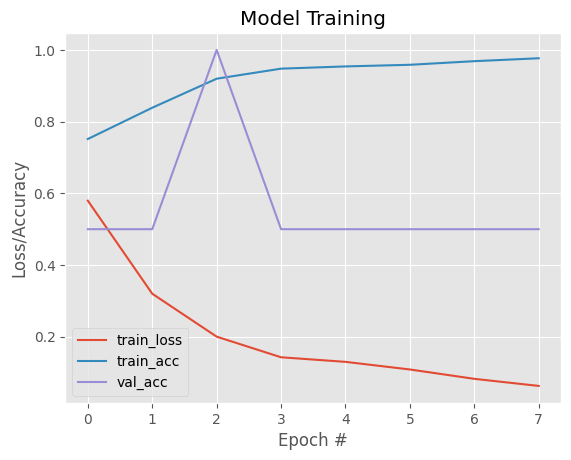

In [16]:
# Plot training history
plt.style.use("ggplot")
plt.figure()
plt.plot(hist.history["loss"], label="train_loss")
plt.plot(hist.history["accuracy"], label="train_acc")
plt.plot(hist.history["val_accuracy"], label="val_acc")
plt.title("Model Training")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig("val_epochs.png")

In [21]:
os.makedirs("saved_models", exist_ok=True)
model.save("saved_models/pneumoniaCGAN_model.h5")  # You can also use .keras or SavedModel
print(" Model saved to 'saved_models/pneumoniaCGAN_model.h5'")

 Model saved to 'saved_models/pneumoniaCGAN_model.h5'


In [22]:
import tensorflow
from tensorflow.keras.models import load_model

# Load your saved model
model = load_model('/kaggle/working/saved_models/pneumoniaCGAN_model.h5')

In [23]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Load your trained model
model = load_model('/kaggle/working/saved_models/pneumoniaCGAN_model.h5')

In [26]:
# Load and preprocess your custom image
img = load_img('/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person100_bacteria_478.jpeg', target_size=(224, 224))
img = img_to_array(img)
img = img / 255.0  # normalize to [0, 1]
img = np.expand_dims(img, axis=0)  # reshape to (1, 128, 128, 3)

# Run prediction
prediction = model.predict(img)

# Show result
if prediction[0][0] > 0.5:
    print(" Normal chest X-ray.")
else:
    print(" Pneumonia detected!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
 Pneumonia detected!
Confidence Score: 0.00%


In [ ]:

from sklearn.metrics.pairwise import cosine_similarity
import faiss

# Step 1: Build FAISS index
def build_faiss_index(feature_list):
    dimension = feature_list.shape[1]
    index = faiss.IndexFlatL2(dimension)
    index.add(feature_list)
    return index

# Step 2: Retrieve similar image features
def retrieve_similar_features(index, query_feature, top_k=5):
    distances, indices = index.search(query_feature, top_k)
    return indices